A loan company data of previous loan applications.<br>
The predictors are collected by loan officers and from client surveys.<br>
The Target is a binary variable with 1 as accepted and 0 rejected applications.<br>

In [2]:
#import libraries
import pandas as pd #pandas class
import numpy as np
import traceback
import os
import copy
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import category_encoders as ce
import time
from scipy.stats import chi2_contingency
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
plt.style.use('_mpl-gallery')

In [161]:
#Read training/test files.
try:
    
    def read_files(file_path_dict: dict):
            file_path=file_path_dict #change to local
        
            output={}
            for index in range(len(file_path)):
                df=pd.read_csv(list(file_path.values())[index])
            
                output['df_'+list(file_path.keys())[index]]=df
            print(f'Read {len(output)} files.')
            return output
    
    if __name__=='__main__':
        
        file_dict={'application_test':"C:\\Custom\\Semester 2\\CA683 DADM\\Home Loan Approval System\\application_test.csv",\
           'application_train':"C:\\Custom\\Semester 2\\CA683 DADM\\Home Loan Approval System\\application_train.csv",\
          }
        
        output=read_files(file_dict)
        
        #take backup of all dataframes
        output_copy=copy.deepcopy(output)
        
except Exception as ex:
    print(f'Following exception:\n {ex}')
    traceback.print_exc()

Read 2 files.


In [162]:
#backup var of training file
df=copy.deepcopy(output['df_application_train'])

Preliminary EDA

In [163]:
#122 columns, 307511 rows
df.shape

(307511, 122)

In [164]:
df.columns
df.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [165]:
'''Understand the distribution of the response variable.'''

'Understand the distribution of the response variable.'

In [166]:
#Any other values in target column.
df.TARGET.unique()

array([1, 0])

'Most of them are rejected applications.'

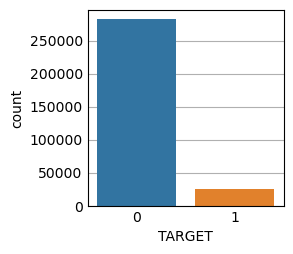

In [167]:
sns.countplot(x=df.TARGET)
'''Most of them are rejected applications.'''

In [168]:
'''Lets check for any missing data in predictors and response columns.'''
df.isna().sum()
(df.isna().sum()>0).value_counts()

True     67
False    55
dtype: int64

In [169]:
'''No missing data in response column.
 67 columns have missing data. Checking for each column and imputing will be tough.
 Possible reasons: 
     Merging of source datasets.
     Random events
     Failure of measurements.
 Kind of missing data:
     Structural deficiencies
     Random occurrences (MCAR, MAR)
     Specific causes (NMAR)
 Limitations:
     All the imputation techniques to fill the missing values should be chosen considering the limitations of computation capacity.
'''
#check only for object type missing columns
df.select_dtypes(include='object').isna().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [46]:
#only 6 categorical columns have missing data. Let analyse these 6 columns first.

df['NAME_TYPE_SUITE'].isna().sum()/df.shape[0]

#What if the categorical columns that are missing has very high association with other categories and all has missing values together?
#The wise option would be to keep only one of these predictor for further analysis.

0.004201475719567756

<AxesSubplot:xlabel='NAME_TYPE_SUITE', ylabel='count'>

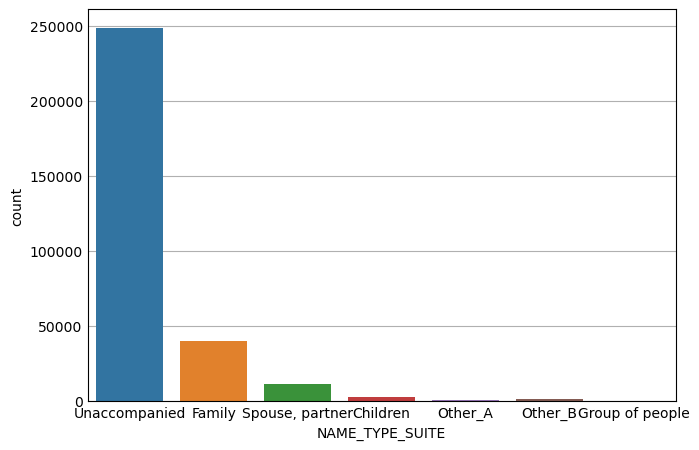

In [43]:
#who was accompanied client when he was applying for the loan.
plt.figure(figsize=(6,4))
sns.countplot(x=df['NAME_TYPE_SUITE'])

In [45]:
df['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [51]:
#The most common value check in assocation with the response.
list(map(lambda value: df[df.TARGET==value]['NAME_TYPE_SUITE'].mode()[0],df.TARGET.unique()))

#The value 'Unaccompanied' is the most common occurrence and since the number of missing values are around 0.04 percent, mode imputation
#is one approach.

['Unaccompanied', 'Unaccompanied']

In [170]:
df['NAME_TYPE_SUITE'].fillna(value=df['NAME_TYPE_SUITE'].mode()[0],inplace=True)

In [171]:
#The name of  column FONDKAPREMONT_MODE is not english but I couldn't find anything related to it to rename.
#rename columns
df.rename(columns={'FONDKAPREMONT_MODE':'FONDKAPREMONT','HOUSETYPE_MODE':'HOUSETYPE','WALLSMATERIAL_MODE':'WALLSMATERIAL','EMERGENCYSTATE_MODE':'EMERGENCYSTATE'},inplace=True)

In [67]:
df['FONDKAPREMONT'].isna().sum()/df.shape[0]

0.6838617155158677

<AxesSubplot:xlabel='FONDKAPREMONT', ylabel='count'>

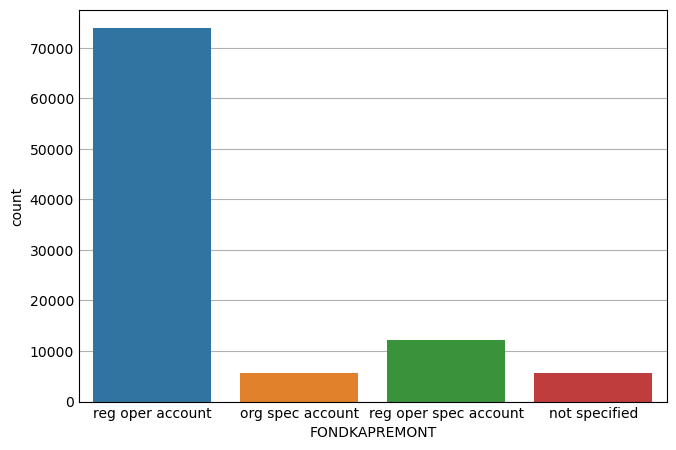

In [69]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['FONDKAPREMONT'])

In [172]:
'''Interesting there is already a value 'not specified' in the dataset. However, assiging the missing value to it might create 
    some bias.
    On careful consideration, the missing values appears to be missing completely at random. 
    Encoding missing approach seems reasonable.
'''
#assign category Unknown to missing values
df['FONDKAPREMONT'].fillna('Unknown',inplace=True)

<AxesSubplot:xlabel='HOUSETYPE', ylabel='count'>

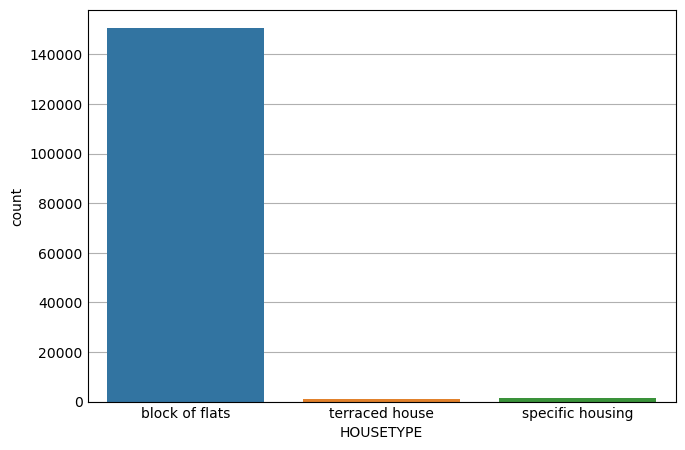

In [72]:
df['HOUSETYPE'].isna().sum()/df.shape[0]
plt.figure(figsize=(6,4))
sns.countplot(x=df['HOUSETYPE'])

In [173]:
'''Mode technique suggest 'block of flats' but it can create the bias.'''
#assign category Unknown to missing values
df['HOUSETYPE'].fillna('Unknown',inplace=True)

<AxesSubplot:xlabel='WALLSMATERIAL', ylabel='count'>

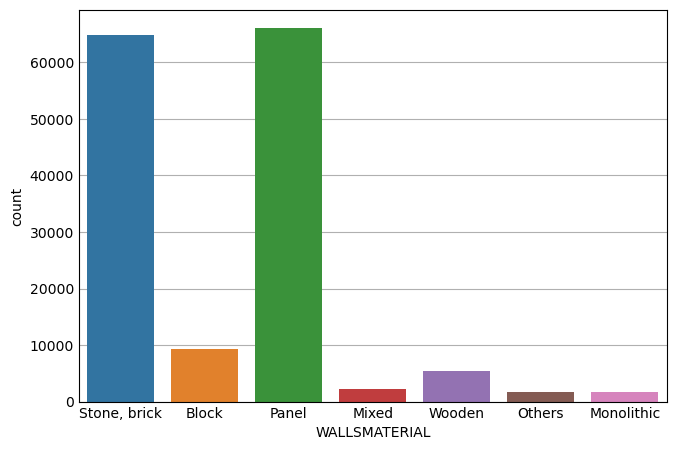

In [174]:
df['WALLSMATERIAL'].isna().sum()/df.shape[0] #50 percent missing values.
plt.figure(figsize=(6,4))
sns.countplot(x=df['WALLSMATERIAL'])

In [79]:
#The most common value check in assocation with the response.
list(map(lambda value: df[df.TARGET==value]['WALLSMATERIAL'].mode()[0],df.TARGET.unique()))

['Stone, brick', 'Panel']

In [176]:
#assign category Unknown to missing values
df['WALLSMATERIAL'].fillna('Unknown',inplace=True)

<AxesSubplot:xlabel='OCCUPATION_TYPE', ylabel='count'>

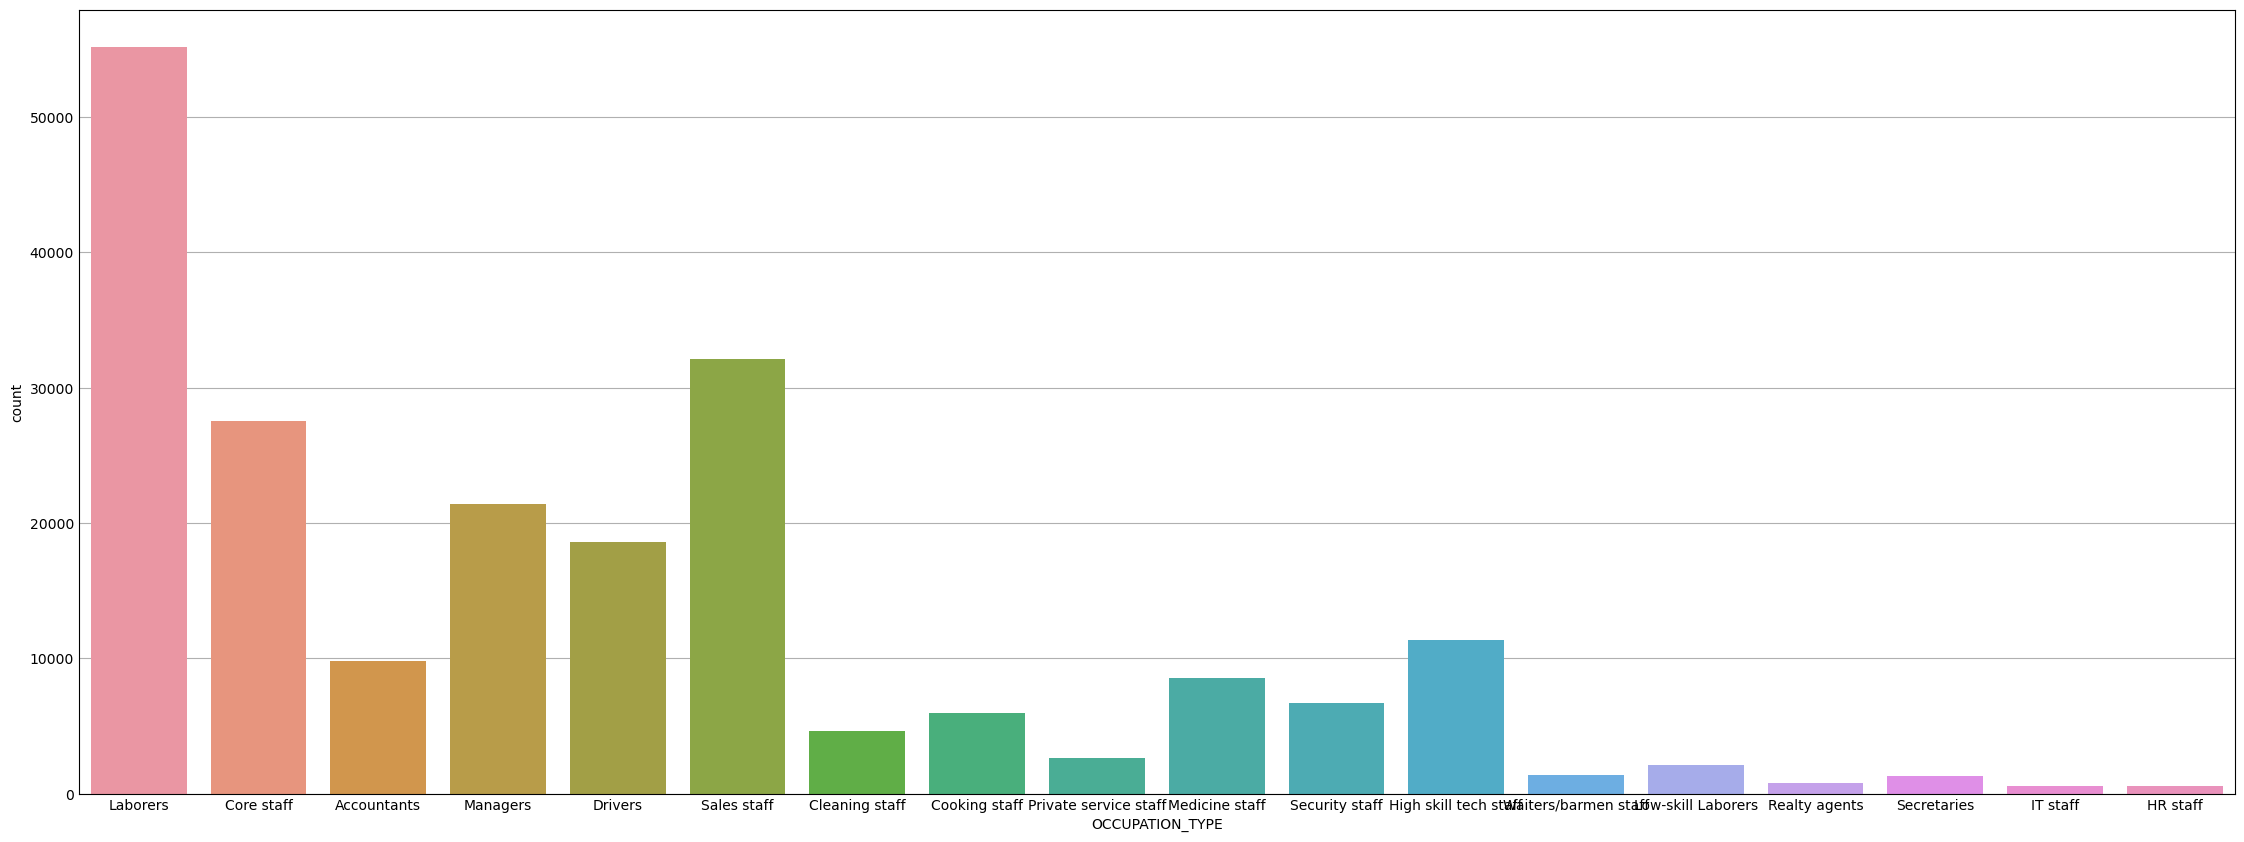

In [122]:
df['OCCUPATION_TYPE'].isna().sum()/df.shape[0] #31 percent missing values.
plt.figure(figsize=(22,8))
sns.countplot(x=df['OCCUPATION_TYPE'])

In [123]:
#The most common value check in assocation with the response.
list(map(lambda value: df[df.TARGET==value]['OCCUPATION_TYPE'].mode()[0],df.TARGET.unique()))

['Laborers', 'Laborers']

In [177]:
#Number of categories is high plus the values are missing at random
#assign category Unknown to missing values to avoid bias against any other category.
df['OCCUPATION_TYPE'].fillna('Unknown',inplace=True)

<AxesSubplot:xlabel='EMERGENCYSTATE', ylabel='count'>

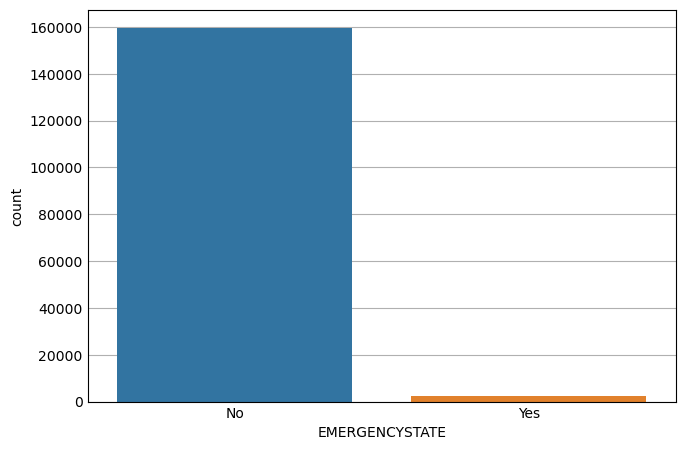

In [82]:
df['EMERGENCYSTATE'].isna().sum()/df.shape[0] #47 percent missing values.
plt.figure(figsize=(6,4))
sns.countplot(x=df['EMERGENCYSTATE'])

In [259]:
#Assigning a new category maybe not be a good idea in binary variable.
#Apply mode encoding
df['EMERGENCYSTATE'].fillna(value=df['EMERGENCYSTATE'].mode()[0],inplace=True)

In [128]:
'''

Now we need to encode our other categorical variables.
'''


"For above column, we'll use a simple bagging trees model to predict the missing values in the 'EMERGENCYSTATE' column.\nWe choose bagged trees because it has been studied that with 25-50 estimators they work really good and the tree-based model are not\naffected by missing values in other columns."

In [192]:
df.select_dtypes(include='object')
#16 columns are to be encoded.

#let's check for all ordered and unordered data in categorical variables.

list(map(lambda column: {column:len(backup[column].unique())},backup.select_dtypes(include='object').columns))

[{'NAME_CONTRACT_TYPE': 2},
 {'CODE_GENDER': 3},
 {'FLAG_OWN_CAR': 2},
 {'FLAG_OWN_REALTY': 2},
 {'NAME_TYPE_SUITE': 7},
 {'NAME_INCOME_TYPE': 8},
 {'NAME_EDUCATION_TYPE': 5},
 {'NAME_FAMILY_STATUS': 6},
 {'NAME_HOUSING_TYPE': 6},
 {'OCCUPATION_TYPE': 19},
 {'WEEKDAY_APPR_PROCESS_START': 7},
 {'ORGANIZATION_TYPE': 58},
 {'FONDKAPREMONT': 5},
 {'HOUSETYPE': 4},
 {'WALLSMATERIAL': 8},
 {'EMERGENCYSTATE': 3}]

In [183]:
'''WEEKDAY_APPR_PROCESS_START is an ordered data, rest all are unordered.

    for column WEEKDAY_APPR_PROCESS_START we'll use label encoding.'''
labels={'MONDAY':0,'TUESDAY':1,'WEDNESDAY':2,'THURSDAY':3,'FRIDAY':4,'SATURDAY':5,'SUNDAY':6}
for key in labels:
    df.loc[df['WEEKDAY_APPR_PROCESS_START']==key,'WEEKDAY_APPR_PROCESS_START']=labels[key] 
    
#convert datatype to int
df['WEEKDAY_APPR_PROCESS_START']=df['WEEKDAY_APPR_PROCESS_START'].astype('int')

In [186]:
'''Columns where number of categories are less than 10, dummies are created.'''

dummies=pd.DataFrame()

def create_dummies(dummies_list: list):
    '''This function will create dummies for all the elements in the list positional argument.'''
    df_dummy = pd.DataFrame()
    for index in dummies_list:
        print (f'Creating dummies for column {index}')
        global dummies
        df_dummy=pd.get_dummies(data=df[index],drop_first=True,prefix=str(index))
        dummies[df_dummy.columns]=df_dummy
    del df_dummy   
    return

if __name__=='__main__':
    dummies_list=['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FONDKAPREMONT','HOUSETYPE','WALLSMATERIAL']
    create_dummies(dummies_list)

Creating dummies for column NAME_CONTRACT_TYPE
Creating dummies for column CODE_GENDER
Creating dummies for column FLAG_OWN_CAR
Creating dummies for column FLAG_OWN_REALTY
Creating dummies for column NAME_TYPE_SUITE
Creating dummies for column NAME_INCOME_TYPE
Creating dummies for column NAME_EDUCATION_TYPE
Creating dummies for column NAME_FAMILY_STATUS
Creating dummies for column NAME_HOUSING_TYPE
Creating dummies for column FONDKAPREMONT
Creating dummies for column HOUSETYPE
Creating dummies for column WALLSMATERIAL


In [188]:
#dummies
df[dummies.columns]=dummies

In [229]:
'''Let us Hash encoder on the other two columns with 19 and 58 categories.
    **Need to make sure there are no collisions in the hashing values.
    
''' 

#8 components will be used in to hash 'OCCUPATION_TYPE' column.
encoders=ce.HashingEncoder(cols='OCCUPATION_TYPE',n_components=8)
enc=encoders.fit_transform(df['OCCUPATION_TYPE'])

#rename the column in enc
enc.rename(columns={'col_0':'OCCUPATION_TYPE_col_0','col_1':'OCCUPATION_TYPE_col_1','col_2':'OCCUPATION_TYPE_col_2',\
                 'col_3':'OCCUPATION_TYPE_col_3','col_4':'OCCUPATION_TYPE_col_4','col_5':'OCCUPATION_TYPE_col_5',\
                 'col_6':'OCCUPATION_TYPE_col_6','col_7':'OCCUPATION_TYPE_col_7'},inplace=True)

#add the newly created hash features columns to df frame.
df[enc.columns]=enc

In [239]:
'''Let us Hash encoder on the other two columns with 19 and 58 categories.
    **Need to make sure there are no collisions in the hashing values.
    
''' 

#8 components will be used in to hash 'ORGANIZATION_TYPE' column.
encoders=ce.HashingEncoder(cols='ORGANIZATION_TYPE',n_components=15)
enc=encoders.fit_transform(df['ORGANIZATION_TYPE'])

#rename the column in enc
enc.rename(columns={'col_0':'ORGANIZATION_TYPE_col_0','col_1':'ORGANIZATION_TYPE_col_1','col_2':'ORGANIZATION_TYPE_col_2',\
                'col_3':'ORGANIZATION_TYPE_col_3','col_4':'ORGANIZATION_TYPE_col_4','col_5':'ORGANIZATION_TYPE_col_5',\
                'col_6':'ORGANIZATION_TYPE_col_6','col_7':'ORGANIZATION_TYPE_col_7','col_8':'ORGANIZATION_TYPE_col_8',\
                'col_9':'ORGANIZATION_TYPE_col_9','col_10':'ORGANIZATION_TYPE_col_10','col_11':'ORGANIZATION_TYPE_col_11',\
                'col_12':'ORGANIZATION_TYPE_col_12','col_13':'ORGANIZATION_TYPE_col_13','col_14':'ORGANIZATION_TYPE_col_14',\
                },inplace=True)

#add the newly created hash features columns to df frame.
df[enc.columns]=enc

In [244]:
#drop the categorical columns
df.drop(columns=['ORGANIZATION_TYPE','OCCUPATION_TYPE'],inplace=True)
df.drop(columns=['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',\
                 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FONDKAPREMONT','HOUSETYPE','WALLSMATERIAL']\
        ,inplace=True)

In [269]:
df_dummy=pd.get_dummies(data=df['EMERGENCYSTATE'],drop_first=True,prefix=str('EMERGENCYSTATE'))
df['EMERGENCYSTATE']=df_dummy

In [279]:
'''All the categorical columns are imputated and encoded'''

'''61 numercial columns with missing values are left.'''

#(df.isna().sum()>0).value_counts()
df.isna().sum().sort_values(ascending=False)[:60]

COMMONAREA_AVG                  214865
COMMONAREA_MEDI                 214865
COMMONAREA_MODE                 214865
NONLIVINGAPARTMENTS_MODE        213514
NONLIVINGAPARTMENTS_MEDI        213514
NONLIVINGAPARTMENTS_AVG         213514
LIVINGAPARTMENTS_MEDI           210199
LIVINGAPARTMENTS_MODE           210199
LIVINGAPARTMENTS_AVG            210199
FLOORSMIN_MODE                  208642
FLOORSMIN_MEDI                  208642
FLOORSMIN_AVG                   208642
YEARS_BUILD_MODE                204488
YEARS_BUILD_AVG                 204488
YEARS_BUILD_MEDI                204488
OWN_CAR_AGE                     202929
LANDAREA_MODE                   182590
LANDAREA_MEDI                   182590
LANDAREA_AVG                    182590
BASEMENTAREA_MEDI               179943
BASEMENTAREA_AVG                179943
BASEMENTAREA_MODE               179943
EXT_SOURCE_1                    173378
NONLIVINGAREA_MODE              169682
NONLIVINGAREA_MEDI              169682
NONLIVINGAREA_AVG        

In [ ]:
'''We'll start with column with least missing values.'''


In [280]:
df['DAYS_LAST_PHONE_CHANGE'].describe()

count    307510.000000
mean       -962.858788
std         826.808487
min       -4292.000000
25%       -1570.000000
50%        -757.000000
75%        -274.000000
max           0.000000
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [322]:
def box(column):
    '''A shortcut to generate box plot of columns.'''
    sns.set(rc={'figure.figsize':(5.1,3.27)})
    sns.boxplot(y=df[column])
    
def hist(column,bins='auto'):
    '''A shortcut to generate historgram of columns.'''
    sns.set(rc={'figure.figsize':(7.7,3.27)})
    sns.histplot(data=df,x=df[column])

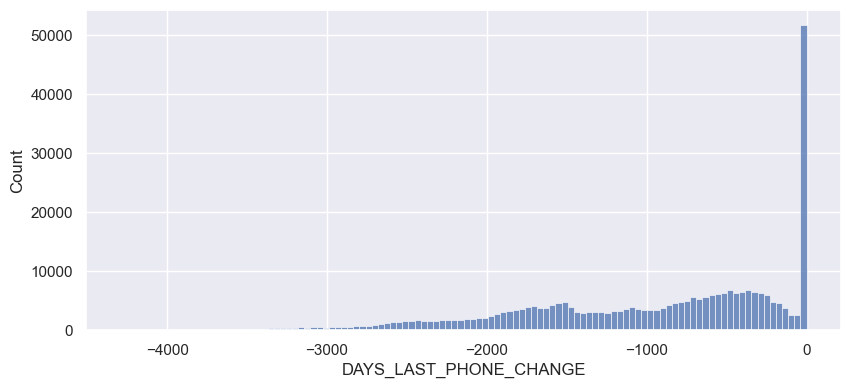

In [324]:

hist('DAYS_LAST_PHONE_CHANGE')


In [325]:
'''Only one missing value in column 'DAYS_LAST_PHONE_CHANGE'.'''

#fill the missing value with median because of skewness in the data.
df['DAYS_LAST_PHONE_CHANGE'].fillna(round(df['DAYS_LAST_PHONE_CHANGE'].median(),4),inplace=True)

In [326]:
df['CNT_FAM_MEMBERS'].describe()

count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

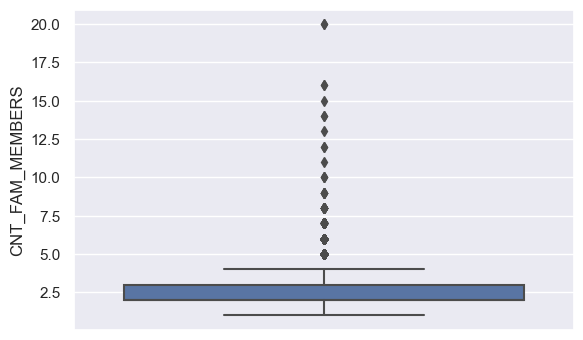

In [331]:
box('CNT_FAM_MEMBERS') #Outliers are present but not too many and given the demorgraphics of the data it is possible to have such values.

In [332]:
#fill the missing value with median because of skewness in the data.
df['CNT_FAM_MEMBERS'].fillna(round(df['CNT_FAM_MEMBERS'].median(),4),inplace=True)

In [333]:
df['AMT_ANNUITY'].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

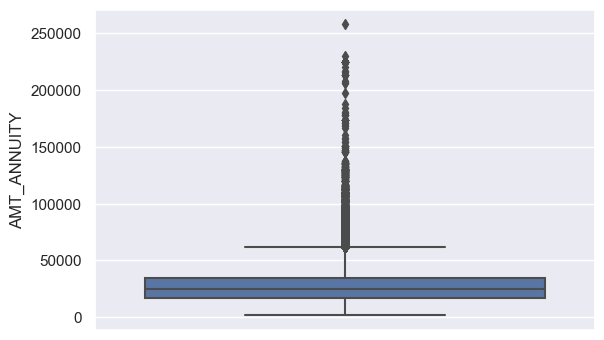

In [334]:
box('AMT_ANNUITY')

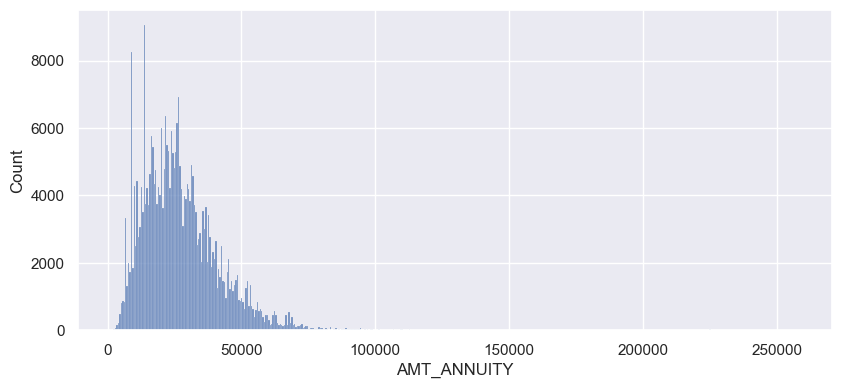

In [335]:
hist('AMT_ANNUITY')

In [336]:
#fill the missing value with median because of skewness in the data.
df['AMT_ANNUITY'].fillna(round(df['AMT_ANNUITY'].median(),4),inplace=True)

In [337]:
df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].isna().sum()

EXT_SOURCE_1    173378
EXT_SOURCE_2       660
EXT_SOURCE_3     60965
dtype: int64

In [ ]:
#A correlation variable 
corr=df.corr()

In [348]:
corr['EXT_SOURCE_1'].sort_values()

DAYS_BIRTH                   -0.600610
CODE_GENDER_M                -0.306737
FLAG_EMP_PHONE               -0.294147
NAME_INCOME_TYPE_Working     -0.186366
REG_CITY_NOT_WORK_CITY       -0.185953
                                ...   
NAME_INCOME_TYPE_Pensioner    0.294434
EXT_SOURCE_1                  1.000000
FLAG_MOBIL                         NaN
OCCUPATION_TYPE_col_0              NaN
OCCUPATION_TYPE_col_4              NaN
Name: EXT_SOURCE_1, Length: 177, dtype: float64

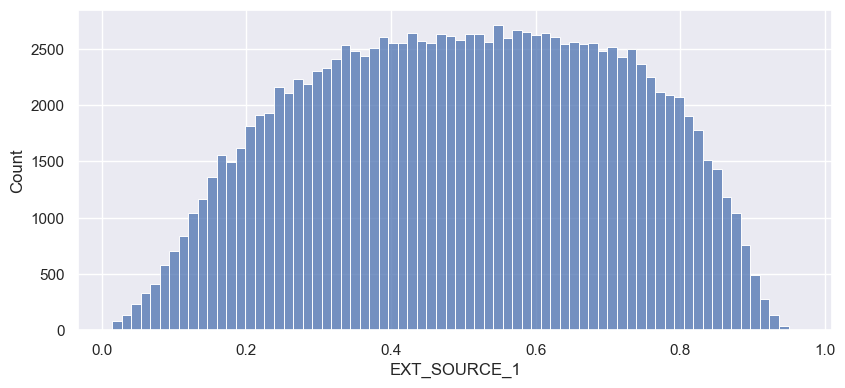

In [350]:
hist('EXT_SOURCE_1') #This column is already normalised.

In [351]:
df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].mean(),inplace=True)

In [352]:
corr['EXT_SOURCE_2'].sort_values()

REGION_RATING_CLIENT          -0.292895
REGION_RATING_CLIENT_W_CITY   -0.288299
DAYS_LAST_PHONE_CHANGE        -0.195764
TARGET                        -0.160472
WALLSMATERIAL_Unknown         -0.121021
                                 ...   
EXT_SOURCE_1                   0.213982
EXT_SOURCE_2                   1.000000
FLAG_MOBIL                          NaN
OCCUPATION_TYPE_col_0               NaN
OCCUPATION_TYPE_col_4               NaN
Name: EXT_SOURCE_2, Length: 177, dtype: float64

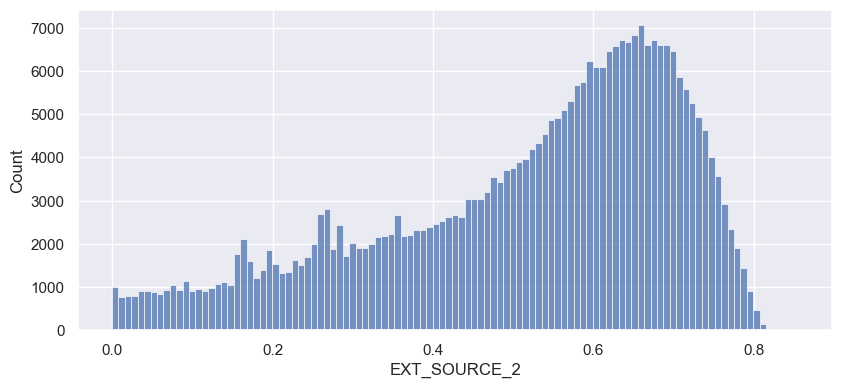

In [353]:
hist('EXT_SOURCE_2') #skewness in the data.

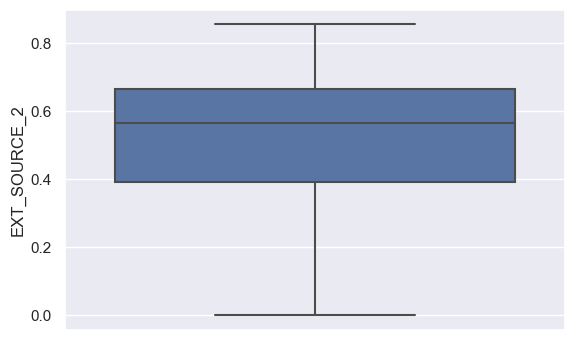

In [354]:
box('EXT_SOURCE_2')

In [359]:
df['EXT_SOURCE_2'].mean()
df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].mean(),inplace=True)

In [360]:
df['EXT_SOURCE_3'].describe()

count    246546.000000
mean          0.510853
std           0.194844
min           0.000527
25%           0.370650
50%           0.535276
75%           0.669057
max           0.896010
Name: EXT_SOURCE_3, dtype: float64

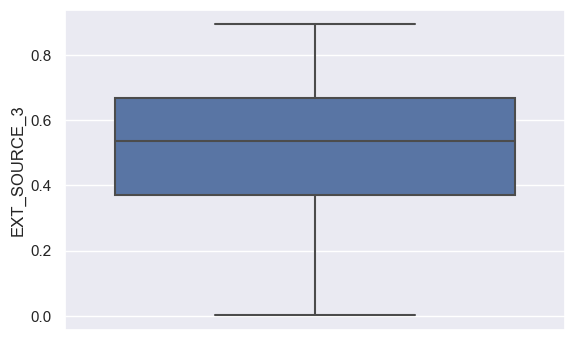

In [361]:
box('EXT_SOURCE_3')

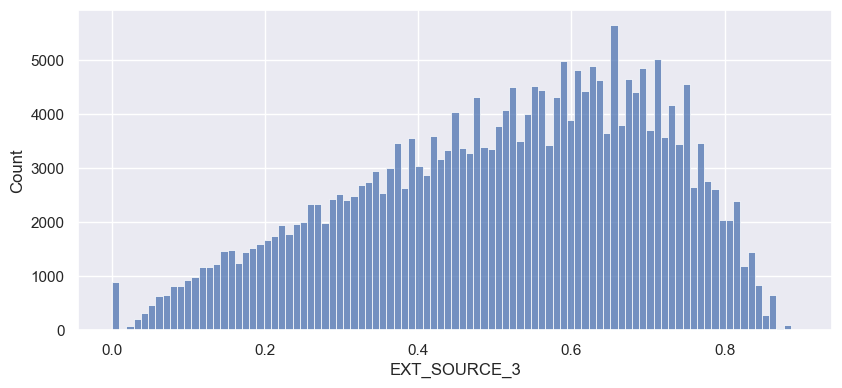

In [362]:
hist('EXT_SOURCE_3')

In [363]:
df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].mean(),inplace=True)

In [369]:
corr['OBS_60_CNT_SOCIAL_CIRCLE'].sort_values()

NAME_EDUCATION_TYPE_Higher education   -0.045448
NAME_TYPE_SUITE_Unaccompanied          -0.043736
FLOORSMAX_AVG                          -0.036789
FLOORSMAX_MEDI                         -0.036390
FLOORSMAX_MODE                         -0.035183
                                          ...   
DEF_30_CNT_SOCIAL_CIRCLE                0.331571
OBS_30_CNT_SOCIAL_CIRCLE                0.998490
OBS_60_CNT_SOCIAL_CIRCLE                1.000000
OCCUPATION_TYPE_col_0                        NaN
OCCUPATION_TYPE_col_4                        NaN
Name: OBS_60_CNT_SOCIAL_CIRCLE, Length: 177, dtype: float64

In [370]:
'''Column 'OBS_60_CNT_SOCIAL_CIRCLE' and 'OBS_30_CNT_SOCIAL_CIRCLE' are 99 percent correlated. So, only one column is required.'''

df.drop(columns=['OBS_60_CNT_SOCIAL_CIRCLE'],inplace=True)

In [376]:
corr['OBS_30_CNT_SOCIAL_CIRCLE'].sort_values(ascending=False)

OBS_30_CNT_SOCIAL_CIRCLE                             1.000000
DEF_30_CNT_SOCIAL_CIRCLE                             0.329338
DEF_60_CNT_SOCIAL_CIRCLE                             0.253499
NAME_EDUCATION_TYPE_Secondary / secondary special    0.044717
REGION_RATING_CLIENT                                 0.034330
                                                       ...   
FLOORSMAX_AVG                                       -0.037018
NAME_TYPE_SUITE_Unaccompanied                       -0.044081
NAME_EDUCATION_TYPE_Higher education                -0.045359
OCCUPATION_TYPE_col_0                                     NaN
OCCUPATION_TYPE_col_4                                     NaN
Name: OBS_30_CNT_SOCIAL_CIRCLE, Length: 176, dtype: float64

In [387]:
df['DEF_60_CNT_SOCIAL_CIRCLE'].describe()
df['OBS_30_CNT_SOCIAL_CIRCLE'].describe()
df['DEF_30_CNT_SOCIAL_CIRCLE'].describe()

count    306490.000000
mean          0.143421
std           0.446698
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          34.000000
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: float64

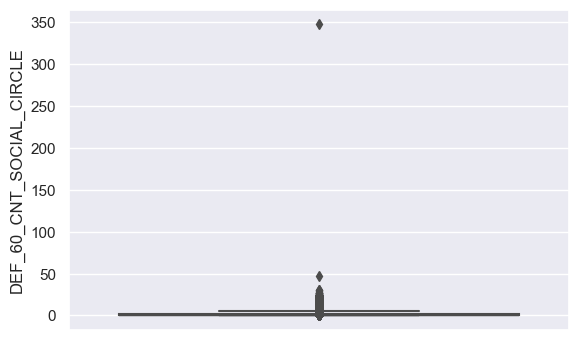

In [386]:
box('DEF_60_CNT_SOCIAL_CIRCLE') #Near zero-variance predictor
box('OBS_30_CNT_SOCIAL_CIRCLE') #Also, near zero-variance predictor
box('DEF_60_CNT_SOCIAL_CIRCLE') #same

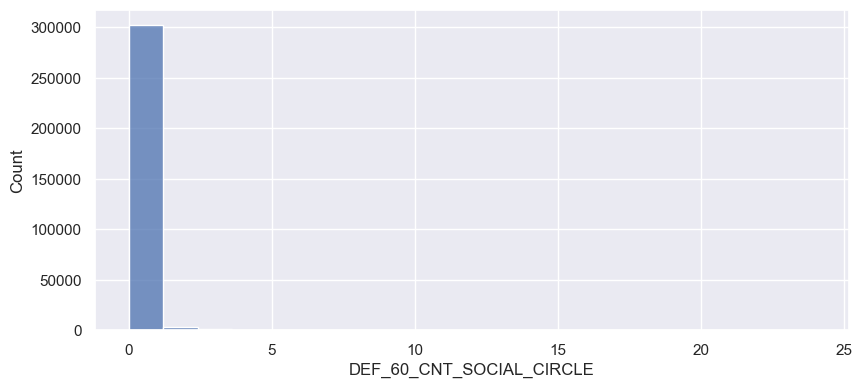

In [392]:
#hist('DEF_60_CNT_SOCIAL_CIRCLE')
#hist('OBS_30_CNT_SOCIAL_CIRCLE')
hist('DEF_60_CNT_SOCIAL_CIRCLE') 

In [ ]:
'''The three columns 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE' are correlated to each other and
    because of computational limitations. I will use only these three columns for now to imputate together.
    Also, the number of neighboars are also contrained to 2.
'''

#build your imputer model
imputer=KNNImputer(n_neighbors=2)
imputer.fit(df[['DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE']])
df_filled_arr=imputer.transform(df[['DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE']])

#convert numpy array to pandas dataframe and fill respective columns
df_filled_frame=pd.DataFrame()
df_filled_frame['DEF_30_CNT_SOCIAL_CIRCLE']=df_filled_arr[:,0]
df_filled_frame['OBS_30_CNT_SOCIAL_CIRCLE']=df_filled_arr[:,1]
df_filled_frame['DEF_60_CNT_SOCIAL_CIRCLE']=df_filled_arr[:,2]

In [ ]:
#Check the correlation to see the effect of imputation.
df_filled_frame[['DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','OBS_30_CNT_SOCIAL_CIRCLE']].corr()

In [ ]:
#find index of null values and impute them
df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(df_filled_frame.iloc[df[df['DEF_30_CNT_SOCIAL_CIRCLE'].isna()].index]['DEF_30_CNT_SOCIAL_CIRCLE'],inplace=True)
df['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(df_filled_frame.iloc[df[df['DEF_60_CNT_SOCIAL_CIRCLE'].isna()].index]['DEF_60_CNT_SOCIAL_CIRCLE'],inplace=True)
df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(df_filled_frame.iloc[df[df['OBS_30_CNT_SOCIAL_CIRCLE'].isna()].index]['OBS_30_CNT_SOCIAL_CIRCLE'],inplace=True)

In [395]:
'''One observation is that columns with same suffix have some correlations and can be used to imputate each other.'''

In [453]:
#repeat same steps for other columns
columns_mode=[]
missing_columns=df.isna().sum().sort_values(ascending=False)[:51].index
for index in missing_columns:
    if '_MODE' in index:
        columns_mode.append(index)
columns_mode


['COMMONAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'YEARS_BUILD_MODE',
 'LANDAREA_MODE',
 'BASEMENTAREA_MODE',
 'NONLIVINGAREA_MODE',
 'ELEVATORS_MODE',
 'APARTMENTS_MODE',
 'ENTRANCES_MODE',
 'LIVINGAREA_MODE',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'TOTALAREA_MODE']

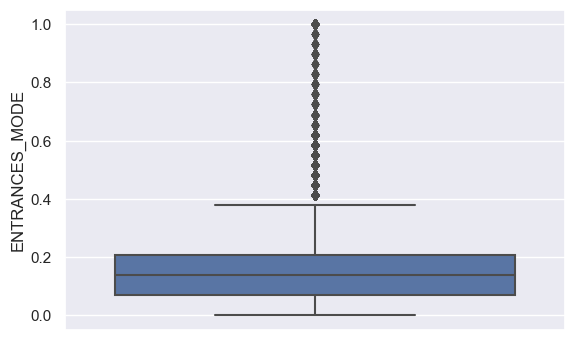

In [425]:
box('ENTRANCES_MODE')

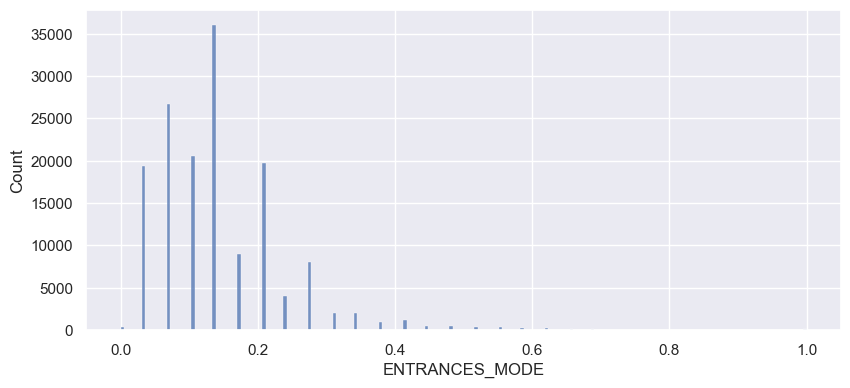

In [424]:
hist('ENTRANCES_MODE')

In [ ]:
'''On analysis all of the columns with suffix '_MODE' also have skewed data.'''

In [429]:
def imputation(columns: list):
    '''The function perform the KNN imputation on list of columns names provided.
        Note-The function has dependency on outer global variables.
    '''
    
    print(f'Inside Imputation function')
    
    #declare global variable
    global df_filled_frame
    global df_filled_backup
    
    #create empty dataframe
    df_filled_frame=pd.DataFrame()
    print(f'Created an empty df_filled_frame dataframe: {df_filled_frame}')

    #build your imputer model
    imputer=KNNImputer(n_neighbors=2)
    imputer.fit(df[columns])
    df_filled_arr=imputer.transform(df[columns])

    #change numpy array values to pandas dataframe for further analysis
    for key,value in enumerate(columns):
        print(f'Index: {key}, Value: {value}')
        df_filled_frame[value]=df_filled_arr[:,key]

In [430]:
def impute_values(columns: list):
    '''This function will take list of column names and imputate them all.
       The imputation procedure is to find correlation among columns and select top 5 correlated variables for a column.
       The correlated variables will then have to pass a check of at least 25 percent (large dataset).
    '''
    corr=df[columns].corr()
    counter=0
    for column in columns:
        print(f'Working on column {column}')
        hold=corr[column].sort_values(ascending=False)[1:6]
        
        if len(hold) >= 4:
            print(f'Top 5 correlated dimensions for {column} are {list(hold.index)}')
            
            if all(hold >= 0.250000):
                print(f'Found correlations more than threshold value (0.25).')
                print(f'Calling imputation function.')
                Start = time.time()
                pass_list = list(hold.index)
                pass_list.append(column)
                print(pass_list)
                imputation(pass_list)
                End=time.time()
                print(f'Imputation for column {column} completed in {(End-Start)/60} minutes')
                
                #This counter is created to allow manual analysis.
                counter+=1
                if counter==5:
                    break
            else: print(f'Feature {column} is not significantly correlated to its top 5 values.')

In [ ]:
#declare the variable and call the function.
global df_filled_frame
global df_filled_backup
impute_values(columns_mode)
df_filled_backup=copy.deepcopy(df_filled_frame)

In [ ]:
'''Check the correlation of filled values to identify any large differences and compare with original dataframe.'''
df_filled_frame.corr()

#All check if there relation with target variable changed.
pd.concat([df_filled_frame,df['TARGET']],axis=1).corr()

In [ ]:
#Fill the missing values in the orignal dataframe.
for index in ['LIVINGAREA_MODE','APARTMENTS_MODE','LIVINGAPARTMENTS_MODE','ELEVATORS_MODE','COMMONAREA_MODE','BASEMENTAREA_MODE']:
    print(f'Imputating missing value of column {index}')
    df[index].fillna(df_filled_frame.iloc[df[df[index].isna()].index][index],inplace=True)

In [ ]:
#The same above technique is applied for all columns with suffix _MODE.

In [432]:
#repeat same steps for other columns
columns_medi=[]
missing_columns=df.isna().sum().sort_values(ascending=False)[:51].index
for index in missing_columns:
    if '_MEDI' in index:
        columns_medi.append(index)
columns_medi

['COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'FLOORSMIN_MEDI',
 'YEARS_BUILD_MEDI',
 'LANDAREA_MEDI',
 'BASEMENTAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'ELEVATORS_MEDI',
 'APARTMENTS_MEDI',
 'ENTRANCES_MEDI',
 'LIVINGAREA_MEDI',
 'FLOORSMAX_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI']

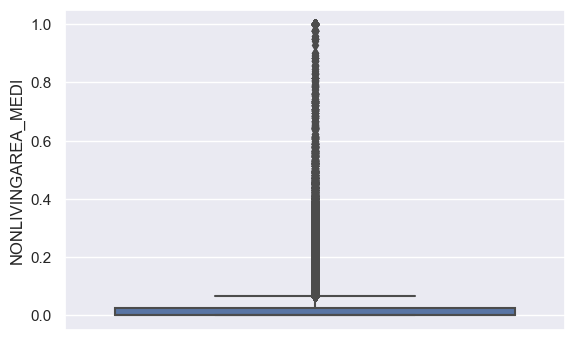

In [439]:
#Check the distribution and summary of all the columns with suffix _MEDI.
box('NONLIVINGAREA_MEDI') #They all have outliers with very small range of values.

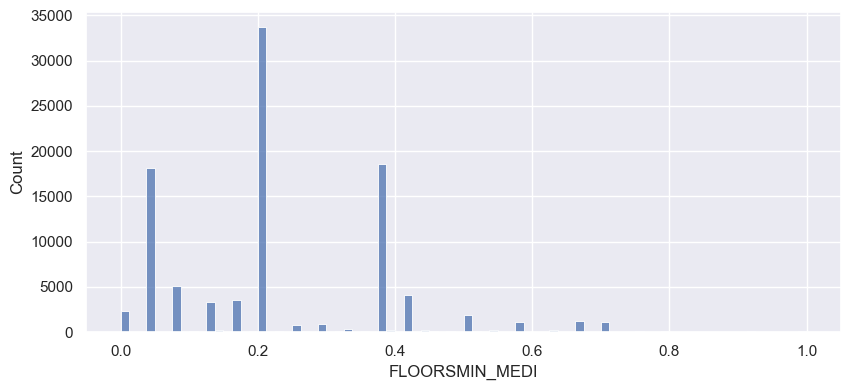

In [443]:
hist('FLOORSMIN_MEDI')

In [ ]:
#Use the same strategy to fill the missing values with suffix _MEDI
#declare the variable and call the function.
global df_filled_frame
global df_filled_backup
impute_values(columns_medi)
df_filled_backup=copy.deepcopy(df_filled_frame)

In [ ]:
'''Check the correlation of filled values to identify any large differences and compare with original dataframe.'''
df_filled_frame.corr()

#All check if there relation with target variable changed.
pd.concat([df_filled_frame,df['TARGET']],axis=1).corr()

In [ ]:
#Fill the missing values in the orignal dataframe.
for index in ['LIVINGAREA_MEDI','APARTMENTS_MEDI','LIVINGAPARTMENTS_MEDI','ELEVATORS_MEDI','COMMONAREA_MEDI','BASEMENTAREA_MEDI']:
    print(f'Imputating missing value of column {index}')
    df[index].fillna(df_filled_frame.iloc[df[df[index].isna()].index][index],inplace=True)

In [444]:
#repeat same steps for other columns
columns_avg=[]
missing_columns=df.isna().sum().sort_values(ascending=False)[:51].index
for index in missing_columns:
    if '_AVG' in index:
        columns_avg.append(index)
columns_avg

['COMMONAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_AVG',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_AVG',
 'LANDAREA_AVG',
 'BASEMENTAREA_AVG',
 'NONLIVINGAREA_AVG',
 'ELEVATORS_AVG',
 'APARTMENTS_AVG',
 'ENTRANCES_AVG',
 'LIVINGAREA_AVG',
 'FLOORSMAX_AVG',
 'YEARS_BEGINEXPLUATATION_AVG']

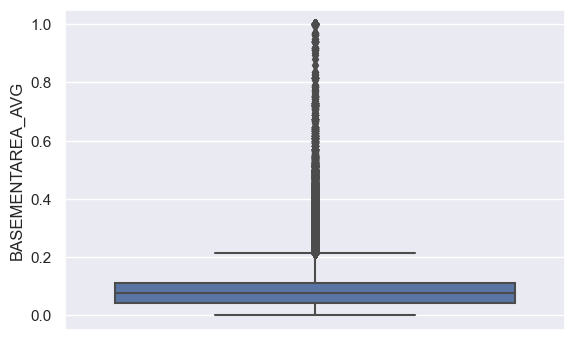

In [449]:
#Check the distribution and summary of all the columns with suffix _MEDI.
box('BASEMENTAREA_AVG') #They all have outliers with very small range of values.

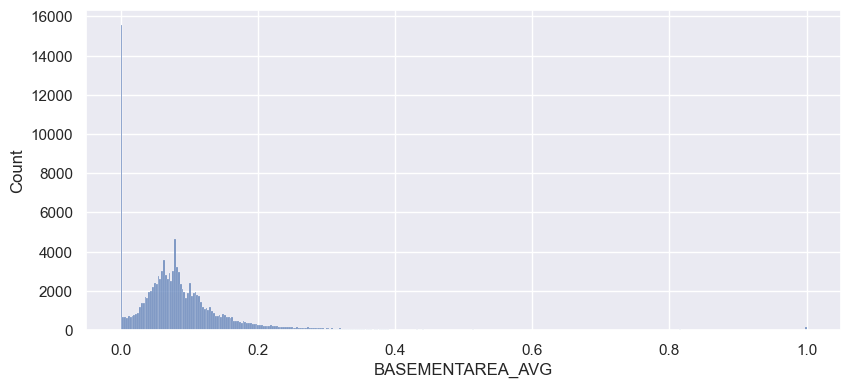

In [450]:
hist('BASEMENTAREA_AVG')

In [ ]:
#Use the same strategy to fill the missing values with suffix _MEDI
#declare the variable and call the function.
global df_filled_frame
global df_filled_backup
impute_values(columns_avg)
df_filled_backup=copy.deepcopy(df_filled_frame)

In [ ]:
'''Check the correlation of filled values to identify any large differences and compare with original dataframe.'''
df_filled_frame.corr()

#All check if there relation with target variable changed.
pd.concat([df_filled_frame,df['TARGET']],axis=1).corr()

In [ ]:
#Fill the missing values in the orignal dataframe.
for index in ['LIVINGAREA_AVG','APARTMENTS_AVG','LIVINGAPARTMENTS_AVG','ELEVATORS_AVG','COMMONAREA_AVG','BASEMENTAREA_AVG']:
    print(f'Imputating missing value of column {index}')
    df[index].fillna(df_filled_frame.iloc[df[df[index].isna()].index][index],inplace=True)

In [477]:
'''There are few columns that were not found correlated with any other columns. So, we will fill them with simple (mean,mode,median)
    imputation.
'''

df['YEARS_BEGINEXPLUATATION_AVG'].fillna(df['YEARS_BEGINEXPLUATATION_AVG'].mean(),inplace=True)
df['YEARS_BEGINEXPLUATATION_MEDI'].fillna(df['YEARS_BEGINEXPLUATATION_MEDI'].mean(),inplace=True)
df['YEARS_BEGINEXPLUATATION_MODE'].fillna(df['YEARS_BEGINEXPLUATATION_MODE'].mean(),inplace=True)
df['NONLIVINGAPARTMENTS_AVG'].fillna(df['NONLIVINGAPARTMENTS_AVG'].mean(),inplace=True)
df['NONLIVINGAPARTMENTS_MEDI'].fillna(df['NONLIVINGAPARTMENTS_MEDI'].mean(),inplace=True)
df['NONLIVINGAPARTMENTS_MODE'].fillna(df['NONLIVINGAPARTMENTS_MODE'].mean(),inplace=True)

In [ ]:
corr['AMT_GOODS_PRICE'].sort_values()

In [481]:
'''The prediction 'AMT_GOODS_PRICE' has only 0.09 percent missing values with almost 99 percent correlation with column 'AMT_CREDIT'. So, we
will drop it.
'''
df.drop(columns='AMT_GOODS_PRICE',inplace=True)

In [488]:
df['OWN_CAR_AGE'].describe()

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

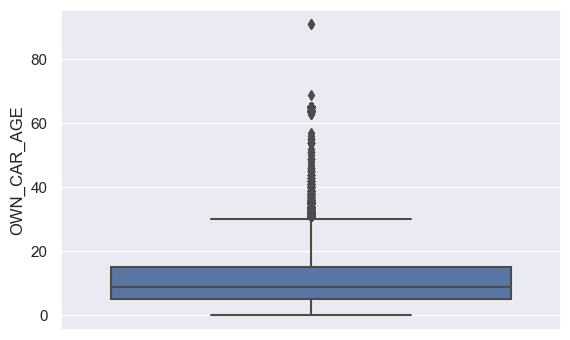

In [489]:
box('OWN_CAR_AGE')

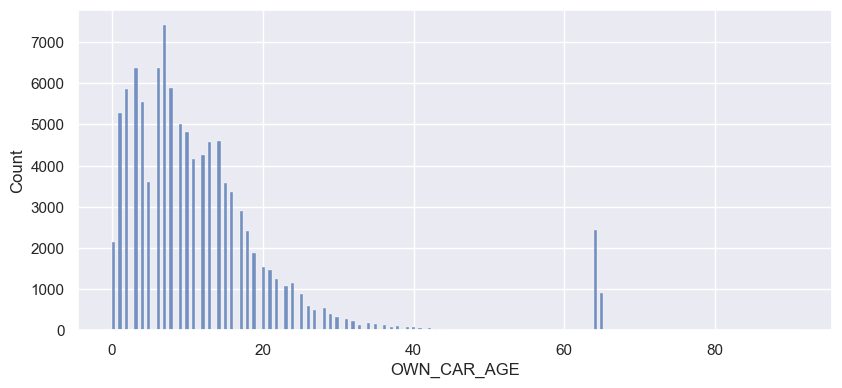

In [490]:
hist('OWN_CAR_AGE') #There's a big spike btw 60-70


In [491]:
'''The column OWN_CAR_AGE has no significant correlation with any other column plus we cannot impuate using all the column.
   Because of the relatively large outliers. We will use median imputation technique for this predictor.
'''

df['OWN_CAR_AGE'].fillna(df['OWN_CAR_AGE'].median(),inplace=True)

In [502]:
'''None of the remaining 6 missing columns are correlated to any other.
'''

corr['AMT_REQ_CREDIT_BUREAU_YEAR'].sort_values(ascending=False)

AMT_REQ_CREDIT_BUREAU_YEAR                           1.000000
AMT_REQ_CREDIT_BUREAU_QRT                            0.076208
FLAG_OWN_REALTY_Y                                    0.067451
NAME_EDUCATION_TYPE_Secondary / secondary special    0.065976
FLAG_EMAIL                                           0.053354
                                                       ...   
DAYS_LAST_PHONE_CHANGE                              -0.112725
FLAG_MOBIL                                                NaN
FLAG_DOCUMENT_2                                           NaN
OCCUPATION_TYPE_col_0                                     NaN
OCCUPATION_TYPE_col_4                                     NaN
Name: AMT_REQ_CREDIT_BUREAU_YEAR, Length: 161, dtype: float64

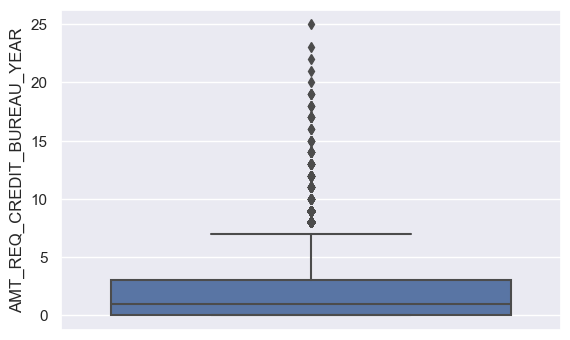

In [508]:
box('AMT_REQ_CREDIT_BUREAU_YEAR')

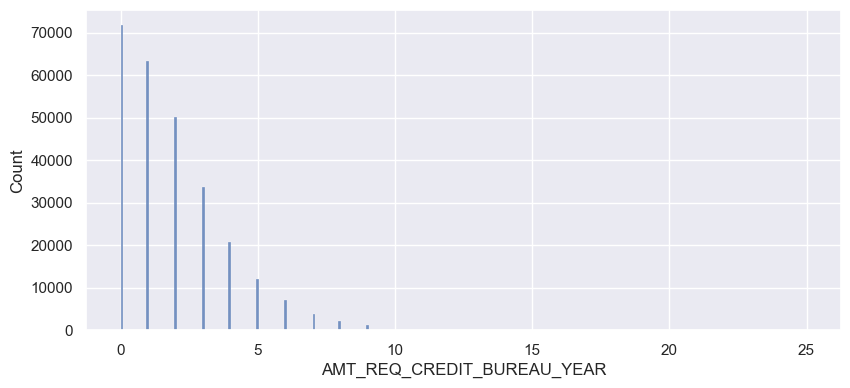

In [514]:
hist('AMT_REQ_CREDIT_BUREAU_YEAR')

In [515]:
'''Most of them have near-zero variance.
    Let's impute them with median.
'''

df['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(df['AMT_REQ_CREDIT_BUREAU_HOUR'].median(),inplace=True)
df['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(df['AMT_REQ_CREDIT_BUREAU_DAY'].median(),inplace=True)
df['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(df['AMT_REQ_CREDIT_BUREAU_WEEK'].median(),inplace=True)
df['AMT_REQ_CREDIT_BUREAU_MON'].fillna(df['AMT_REQ_CREDIT_BUREAU_MON'].median(),inplace=True)
df['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(df['AMT_REQ_CREDIT_BUREAU_QRT'].median(),inplace=True)
df['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(df['AMT_REQ_CREDIT_BUREAU_YEAR'].median(),inplace=True)

In [518]:
'''All the missing value columns are accounted for.'''

In [471]:
'''All the missing values are imputated and also the categorical values are also encoded.
    Before we perform any scaling or normalisation, lets apply a simple feature selection technique to drop
    columns that are high correlated to one another. The threshold is at 90 percent.  
'''

In [535]:
def correlation(n,corr):
    '''This function will print a list of columns that are highly correlated (above 90 percent) to other columns.
    '''
    count=0
    for value in corr.columns.tolist():
        if count==n: break
        else:
            find_corr=corr[corr[value]>0.9000000]
            if find_corr.shape[0]>1:
                print(f'Column {value} has correlations with {corr[corr[value]>0.9200000].iloc[1:].index.tolist()}')
                count+=1
    

corr=df.corr()
correlation(10,corr)

In [472]:
'''In our analysis, we found the below columns highly correlated with some other columns and thus being dropped from our predictors list.

'''

df.drop(columns=['NONLIVINGAPARTMENTS_MEDI', 'YEARS_BUILD_MEDI', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI', 'APARTMENTS_MEDI',\
                 'ENTRANCES_MEDI','LIVINGAREA_MEDI', 'FLOORSMAX_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI'],inplace=True)

df.drop(columns=['NONLIVINGAPARTMENTS_MODE','ELEVATORS_MODE','APARTMENTS_MODE','LIVINGAREA_MODE','FLOORSMAX_MODE',\
                 'YEARS_BEGINEXPLUATATION_MODE','ENTRANCES_MODE'],inplace=True)


In [ ]:
'''The column REGION_RATING_CLIENT_W_CITY is an  discrete predictor for which an association test was performed.'''

df.drop(columns=['REGION_RATING_CLIENT_W_CITY'],inplace=True)

In [540]:
''' Primary key SK_ID_CURR is not required now.'''
df.drop(columns=['SK_ID_CURR'],inplace=True)

' Primary key SK_ID_CURR is not required now.'

In [541]:
df.shape

(307511, 157)

In [519]:
backup=copy.deepcopy(df)

In [ ]:
def backup(df,Uid):
        filepath=f"C:\\Custom\\Semester 2\\CA683 DADM\\Home Loan Approval System\\Cleaning_{Uid}.csv"
        print(f'Backup file: {filepath}')
        df.to_csv(filepath)
        print(f'File created.')
backup(df,2)